# Lanet (v1.2) Add Early Stopping

In [0]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics


def activation(z, act_func):
    global _activation
    if act_func == 'relu':
       return np.maximum(z, np.zeros(z.shape))
    
    elif act_func == 'sigmoid':
      return 1.0/(1.0 + np.exp( -z ))

    elif act_func == 'linear':
        return z
    else:
        raise Exception('Activation function is not defined.')


def get_dactivation(A, act_func):
    if act_func == 'relu':
        return np.maximum(np.sign(A), np.zeros(A.shape)) # 1 if backward input >0, 0 otherwise; then diaganolize

    elif act_func == 'sigmoid':
        h = activation(A, 'sigmoid')
        return h *(1-h)

    elif act_func == 'linear':
        return np.ones(A.shape)

    else:
        raise Exception('Activation function is not defined.')

def loss(y_true, y_predicted, loss_function='mse'):
    if loss_function == 'mse':
      if np.square(y_predicted).sum() > 1E10:
        print(np.square(y_predicted).sum())
      #  raise  Exception('Prediction viel zu hoch beim Lernen!')
      return metrics.mean_squared_error( y_true, y_predicted)
    else:
        raise Exception('Loss metric is not defined.')
          


def get_dZ_from_loss(y, y_predicted, metric):
    if metric == 'mse':
        return y_predicted - y
    else:
        raise Exception('Loss metric is not defined.')

        
class layer:
  def __init__(self,input_dim, output_dim, activation='relu'):    
    self.activation = activation
    self.input_dim = input_dim
    self.output_dim = output_dim # is this needed?? TODO
    if input_dim > 0:
      self.b = np.ones( (output_dim,1) )       
      self.W = np.ones( (output_dim, input_dim) )
      self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2/input_dim) 
    
    self.A = np.zeros( (output_dim,1) ) # added: we temp. store for A
  
  def setWeight(self, W ):
    self.W = W
    
  def setBias(self, b ):
    self.b = b
    
  def setActivation(self, A ): 
    self.Z =  np.add( np.dot(self.W, A), self.b)
    self.A =  activation(self.Z, self.activation)
  
  
  def print(self, layer_name=""):
    print(f"Layer {layer_name}: Begin of Summary")
    if self.input_dim > 0:
      print(f"Layer {layer_name}: input_dim = {self.input_dim}")
      print(f"Layer {layer_name}: output_dim = {self.output_dim}")
      print(f"Layer {layer_name}: Activation = {self.activation}")
      print(f"W = ")
      print(self.W)
      print(f"A = ")
      print(self.A)
      print(f"b = ")
      print(self.b)
    else:
      print(f"Layer {layer_name}: This is an input layer..... ")
      print(f"A = ")
      print(self.A)
  
    print(f"Layer {layer_name}: End of Summary")
  

class ModelNet:
  def __init__(self, input_dim):  
    self.history = []
    self.neural_net = []
    self.neural_net.append(layer(0 , input_dim, 'irrelevant'))
    

  def addLayer(self, nr_neurons, activation='relu'):    
    layer_index = len(self.neural_net)
    input_dim = self.neural_net[layer_index - 1].output_dim
    new_layer = layer( input_dim, nr_neurons, activation)
    self.neural_net.append( new_layer )
    
  #added  
  def get_history(self):
     return pd.DataFrame(
         self.history, 
         columns=['epoch', 'loss', 'weight_sum']
     )         

  def forward_propagation(self, input_vec ):
    self.neural_net[0].A = input_vec
    for layer_index in range(1,len(self.neural_net)):    
      _A_Prev = self.neural_net[layer_index-1].A                       
      self.neural_net[layer_index].setActivation( _A_Prev )
      
    return  self.neural_net[layer_index].A
    
    
  def fit(self, input_vec, y_true, max_epoch, early_stop = 1, learning_rate=0.01, verbose=1 ):
    print(f"Start training for input_vec:")
    print( input_vec)
    print(f"Feature set entries: {input_vec.shape[1]}")
    
    self.learning_rate = learning_rate
    self.history = []  # Reset History Array
    num_train_datum = input_vec.shape[1]

    # Training Loop
    for epoch in range(1,max_epoch+1): 
      weight_norm_sum = 0
     
    
      # Generate y_predicted
      y_predicted = self.forward_propagation( input_vec )

      # Do Backpropagation
      self.backward_propagation( y_true, y_predicted,  num_train_datum, verbose = verbose - 1 )

      #calculate intermediate loss
      cost = loss(y_true, y_predicted)

      # Update history
      self.history.append([epoch, cost, weight_norm_sum])
      

      # Update the weights an biases
      weight_norm_sum = self.update( learning_rate )
      print(f"Weight Norm : {weight_norm_sum}")
      if weight_norm_sum > 1E15:
        print(f"\n\nEpoch {epoch} - Stopped Training, because gradients are exploding ({weight_norm_sum})\n\n")
        break;

      # added: early stopping
      if epoch > 7 and (early_stop == 1):
        actual_loss = self.history[epoch-1][1] # epochs start with one!
        past_loss   = self.history[epoch-6][1] 
        if (abs(actual_loss - past_loss)) < 1E-3:
          print(f"Early stop in after epoch {epoch} with loss  {actual_loss}")
          print(f"   Prev Loss ({epoch-5}) : {past_loss} [Delta: { abs(actual_loss-past_loss) }]")

          break
      

      if (verbose > 0):
        #print(f"Epoch {epoch}: Y-True = {y_true}")
        #print(f"Epoch {epoch}: Y-Pred = {y_predicted}")
        print(f"Epoch {epoch}: Loss   = { cost }")
        #print(f"Epoch {epoch}: Finished")

    print(f"Epoch {epoch}: Y-True = {y_true}")
    print(f"Epoch {epoch}: Y-Pred = {y_predicted}")
    print(f"Epoch {epoch}: Loss = {loss(y_true, y_predicted)}")    
    print(f"Epoch {epoch}: Finished")
      
      
  def backward_propagation(self, y, y_predicted, num_train_datum, metric='mse', verbose=0):
      nr_layers = len(self.neural_net)
      for layer_index in range(nr_layers-1,0,-1):
          if layer_index+1 == nr_layers: # if output layer
              dZ = get_dZ_from_loss(y, y_predicted, metric)
          else: 
              dZ = np.multiply(
                    np.dot(
                        self.neural_net[layer_index+1].W.T, 
                        dZ), 
                    get_dactivation(
                          self.neural_net[layer_index].A, 
                          self.neural_net[layer_index].activation)
                    )
            
          
          dW = np.dot(dZ, self.neural_net[layer_index-1].A.T) / num_train_datum
          db = np.sum(dZ, axis=1, keepdims=True) / num_train_datum
          
          self.neural_net[layer_index].dW = dW
          self.neural_net[layer_index].db = db
          if (verbose > 0):
              print(f"\n\n====== Backward Propagation Layer {layer_index} =======")
              print(f"dZ      =  {dZ}")          
              print(f"dW      =  {dW}")
              print(f"A-1     = {self.neural_net[layer_index-1].A}") 
              print(f"\nb     =  {db}")
             
  # added
  def update( self, learning_rate ):
      nr_layers = len(self.neural_net)
      weight_gradient_norm_sum = 0
      for layer_index in range(1,nr_layers):        
        self.neural_net[layer_index].W = self.neural_net[layer_index].W - learning_rate * self.neural_net[layer_index].dW  
        self.neural_net[layer_index].b = self.neural_net[layer_index].b - learning_rate * self.neural_net[layer_index].db      
        weight_gradient_norm_sum= weight_gradient_norm_sum + np.square( self.neural_net[layer_index].dW ).sum()
      return weight_gradient_norm_sum

  def summary(self):
      print("MODEL SUMMARY")
      for layer_index in range(len(self.neural_net)):        
        self.neural_net[layer_index].print(layer_index)
        
      print("FINISHED MODEL SUMMARY")
      
        





# Test

(1, 10)
Start training for input_vec:
[[ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19.]
 [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]]
Feature set entries: 10
Weight Norm : 720155.2743298304
Weight Norm : 739820.424794121
Weight Norm : 760110.1089789588
Weight Norm : 780867.718674232
Weight Norm : 802281.6954007731
Weight Norm : 824192.4073713399
Weight Norm : 846793.0226914517
Weight Norm : 869920.845272942
Weight Norm : 893773.903599534
Weight Norm : 918186.3971472098
Weight Norm : 943361.353114467
Weight Norm : 969129.8270919167
Weight Norm : 995699.9880599353
Weight Norm : 1022899.7090629764
Weight Norm : 1050942.4488573626
Weight Norm : 1079652.8601798536
Weight Norm : 1109249.8446896065
Weight Norm : 1139554.7980715577
Weight Norm : 1170792.2233631592
Weight Norm : 1202780.223597036
Weight Norm : 1235749.0672391546
Weight Norm : 1269513.5303477817
Weight Norm : 1304309.8166795252
Weight Norm : 1339949.3424185822
Weight Norm : 1376674.4225349168
Weight Norm : 1414293.082014777
Weight Norm :

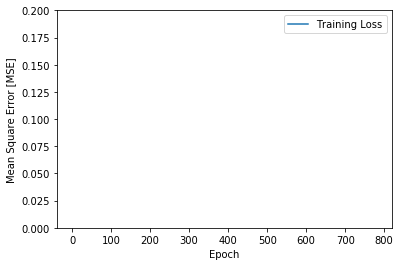

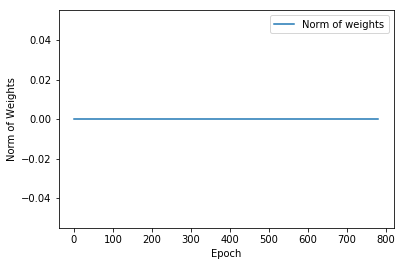

In [70]:
# Add dataloader
def load_random_data_D (N = 100, delta=0.1):
    """ This can be run with just one (output) layer. 
    Set N= 5000, learning_rate=0.005, no autostop
    """
    X = np.arange(1,2*N+1).reshape(N,2) + delta*np.random.rand(N,2)
    x1 = X[:,0]
    x2 = X[:,1]    
    y = np.array([x1 + x2]); 
    print( y.shape )
    return (X, y.T)

#Test        
input_dim = 2
output_dim = 1
model = ModelNet( input_dim )
#model.addLayer( 2, 'relu' )
model.addLayer( output_dim, 'linear' )

(X,y) = load_random_data_D( N=10, delta = 0)
model.fit( X.T, y.T, 5000, early_stop = 1, learning_rate = 0.007, verbose=0)

history = model.get_history()
plt.figure()
plt.plot(history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [MSE]')
plt.ylim([0,0.2])  
plt.legend()
plt.show()

plt.figure()
plt.plot(history['weight_sum'], label='Norm of weights')
plt.xlabel('Epoch')
plt.ylabel('Norm of Weights')
#plt.ylim([0,0.2])  
plt.legend()
plt.show()



# Analyze Gradient Explosion